In [1]:
# Install Comet
# !pip install comet_ml

In [2]:
# Import Comet package
from comet_ml import Experiment

# Setting the API key (saved as environment variable)
"""
Go ahead and get your api_key, project_name & workspace from your
Comet Project Folder.
"""
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="CL3r4k2Kr1MFTRdavZUxjrBSy",
    project_name="team-12-advanced-classification-sentiment-analysis",
    workspace="jeniffermukami",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jeniffermukami/team-12-advanced-classification-sentiment-analysis/bda830fc48874beeaef0394d7766e436



In [3]:
""" For seamless run, Import All required libraries here """

# Libraries for data loading, data manipulation and data visulisation
import pandas as pd                                                   # for loading CSV data
import numpy as np                                                    # Used for mathematical operations
import matplotlib.pyplot as plt                                       # for Graphical Representation
#%matplotlib inline                                                    
import seaborn as sns                                                 # for specialized plots
import re                                                             
import math 
import string
sns.set()                                                             # set plot style

# Libraries for data preparation
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from statsmodels.graphics.correlation import plot_corr                # To plot correlation heatmap
from pandas_profiling import ProfileReport   #Panda Profiling for EDA

# Libraries for Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer   

# Libraries for Model Building
from sklearn.model_selection import train_test_split                  # To split the data into training and testing data
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score                # To split the data into training and testing data
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Libraries for calculating performance metrics
from sklearn import metrics                                           # for
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
import time

# Libraries to Save/Restore Models
import pickle

# Setting global constants to ensure notebook results are reproducible


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [4]:
# Load Data
df_train = pd.read_csv('train.csv')
df_test =pd.read_csv('test_with_no_labels.csv')

In [5]:
# View Dataset
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


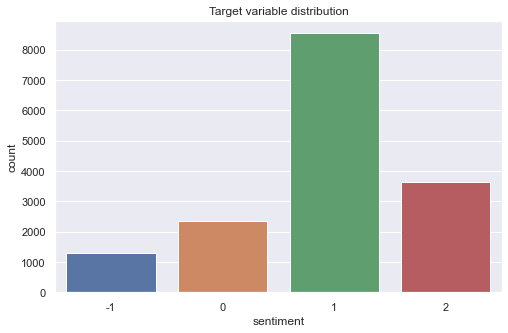

In [6]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(df_train['sentiment'])
plt.title('Target variable distribution')
plt.show()

In [7]:
# First we View Data in MESSAGE COlumns
pd.set_option('display.max_colwidth', -1)      # set to display full text in df
df_train['message'].head(5)

0    PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable
1    It's not like we lack evidence of anthropogenic global warming                                                                              
2    RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
3    #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD                                         
4    RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight                  
Name: message, dtype: object

In [8]:
# First we Define function that handles text cleaning
def clean_text(text):
    """
    This function uses regular expressions to 
        - remove links characters
        - remove html characters,
        - remove escape sequences,
        - remove capitalization,
        - any extra white space from each text and then converts them to lowercase.

    Input:
    text: original text
          datatype: string

    Output:
    texts: modified text
           datatype: string
    """
    # replace links with url-web
    pattern_url = 'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = 'url-web'
    text = re.sub(pattern_url, subs_url, text)
    # replace the html characters with " "
    text = re.sub('<.*?>', ' ', text)
    # replace escape sequence with space
    escape_seq = ["\r", "\n",'\a', '\b', '\f', "\`", '\”', '\t']
    for i in escape_seq:
        text = re.sub(i, " ", text)
    # Remove Capitalization
    text = text.lower()
    # plit and join the words
    text=' '.join(text.split())
    
    return text

In [9]:
# Applying function to clean text feature
df_train['message'] = df_train['message'].apply(clean_text)
df_test['message'] = df_test['message'].apply(clean_text)

In [10]:
# Let's view the MESSAGE created
pd.set_option('display.max_colwidth', -1)      # set to display full text in df
df_train['message'].head(8)

0    polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? url-web via @mashable            
1    it's not like we lack evidence of anthropogenic global warming                                                                          
2    rt @rawstory: researchers say we have three years to act on climate change before it’s too late url-web url-web…                        
3    #todayinmaker# wired : 2016 was a pivotal year in the war on climate change url-web                                                     
4    rt @soynoviodetodas: it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight              
5    worth a read whether you do or don't believe in climate change url-web url-web                                                          
6    rt @thenation: mike pence doesn’t believe in global warming or that smoking causes lung cancer. url-web                                 
7    r

In [11]:
# Define a function to handle punctuation removal
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

In [12]:
# Remove Punctutaion Noise
df_train['message'] = df_train['message'].apply(remove_punctuation)
df_test['message'] = df_test['message'].apply(remove_punctuation)

In [13]:
# Verify Actions
pd.set_option('display.max_colwidth', -1)      # set to display full text in df
df_train['message'].head(15)

0     polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable                   
1     its not like we lack evidence of anthropogenic global warming                                                                          
2     rt rawstory researchers say we have three years to act on climate change before it’s too late urlweb urlweb…                           
3     todayinmaker wired  2016 was a pivotal year in the war on climate change urlweb                                                        
4     rt soynoviodetodas its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight                     
5     worth a read whether you do or dont believe in climate change urlweb urlweb                                                            
6     rt thenation mike pence doesn’t believe in global warming or that smoking causes lung cancer urlweb                                    
7     

In [14]:
# First features and label 
X = df_train['message']
y = df_train['sentiment']

In [15]:
# split data to Train/Test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=53)

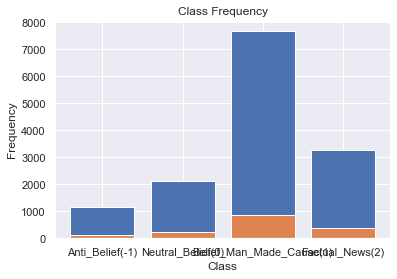

 1    7677
 2    3257
 0    2133
-1    1170
Name: sentiment, dtype: int64

In [16]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts)

plt.rcParams["figure.figsize"] = (25, 3)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[-1, 0, 1, 2], 
           labels=['Anti_Belief(-1)', 'Neutral_Belief(0)', 'Belief_Man_Made_Cause(1)', 'Factual_News(2)'])

plt.show()
y_train.value_counts()

In [17]:
"""
You can go ahead to adding to try other models
this list of classifiers
"""

classifiers = [LinearSVC(),
               
               #SVC(),
               
               MultinomialNB(),
               
               ComplementNB(),
               
               LogisticRegression(),
               
               #RandomForestClassifier(max_depth = 25, random_state = 42),
               
               #KNeighborsClassifier(n_neighbors=5),
               
               #SGDClassifier(loss='hinge',
#                              penalty='l2',
#                              alpha=1e-3,
#                              random_state=42,
#                              max_iter=5,
#                              tol=None)
               ]

In [18]:
def models_building(classifiers, X_train, y_train, X_val, y_val):
    """
    This function takes in a list of classifiers and both the train and validation sets
    and return a summary of F1-score and processing time as a dataframe

    Input:
    classifiers: a list of classifiers to train
                 datatype: list
    X_train: independent variable for training
                 datatype: series
    y_train: dependent variable for training
                 datatype: series
    X_val: independent variable for validation
                 datatype: series
    y_val: dependent variable for validation
                 datatype: series

    Output:
    model_summary: F1 Score for all the classifiers
                 datatype: dataframe
    """

    models_summary = {}

    # Pipeline to balance the classses and then to build the model
    for clf in classifiers:
        clf_para = Pipeline([('countV', CountVectorizer(min_df=1,
                                                       max_df=0.9,
                                                       ngram_range=(1, 2))),
                             ('clf', clf)])

        # Logging the Execution Time for each model
        start_time = time.time()
        clf_para.fit(X_train, y_train)
        predictions = clf_para.predict(X_val)
        run_time = time.time() - start_time

        # Score output for each model
        models_summary[clf.__class__.__name__] = {
            'F1-Macro': metrics.f1_score(y_val,
                                         predictions,
                                         average='macro'),
            'F1-Accuracy': metrics.f1_score(y_val, predictions,
                                            average='micro'),
            'F1-Weighted': metrics.f1_score(y_val,
                                            predictions,
                                            average='weighted'),
            'Execution Time': run_time}

    return pd.DataFrame.from_dict(models_summary, orient='index')

In [19]:
classifiers_df = models_building(classifiers, X_train, y_train, X_val, y_val)

In [20]:
df = classifiers_df.sort_values('F1-Macro', ascending=False)
df

,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LogisticRegression,0.668255,0.759166,0.750182,43.715544
LinearSVC,0.665661,0.749052,0.743451,23.710714
ComplementNB,0.639182,0.749684,0.729198,3.336007
MultinomialNB,0.534525,0.719975,0.676863,3.409449


In [21]:
betterVect = CountVectorizer(min_df=1,
                             max_df=0.9,
                             ngram_range=(1, 2))

In [22]:
# Creating a pipeline for the gridsearch

# set parameter grid
param_grid = {'penalty': ['l1', 'l2',  'elasticnet', 'none'],
             'random_state': [53]}  

hyper_best_model = Pipeline([('countV', betterVect),
                      ('logReg', GridSearchCV(LogisticRegression(),
                                           param_grid=param_grid,
                                           cv=5,
                                           n_jobs=-1,
                                           scoring='f1_weighted'))
                      ])

# Fiting data model
hyper_best_model.fit(X_train, y_train) 

# predicting the fit on validation set
y_pred = hyper_best_model.predict(X_val)  

print(classification_report(y_val, y_pred)) 

              precision    recall  f1-score   support

          -1       0.73      0.39      0.51       126
           0       0.63      0.51      0.57       220
           1       0.78      0.87      0.82       853
           2       0.77      0.79      0.78       383

    accuracy                           0.76      1582
   macro avg       0.73      0.64      0.67      1582
weighted avg       0.75      0.76      0.75      1582



In [23]:
# Create dictionaries for the data we want to log
# This had to be defined since that applied to our model is the best from the grid search.
params ={"random_state": 53,
         "model_type ": "LinearSVC",
         "Bag of words": "count_Vectorizer",
         "scaler": "Standard Scaler",
         "min_df": 1,
         "max_df": 0.9,
         "n_grams": "(1, 2)"
        }

nb_metrics ={"Accuracy": metrics.accuracy_score(y_val, y_pred),
             "recall": metrics.recall_score(y_val, y_pred, average='micro'),
             "f1": metrics.f1_score(y_val, y_pred, average='micro'),
#              "Classification_Report": classification_report(y_val, y_pred)
            }

confusionmatrix = confusion_matrix(y_val, y_pred)

In [24]:
#log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(nb_metrics)
experiment.log_notebook('5.0 Advance_Classification_Notebook.ipynb', overwrite=False)
experiment.log_confusion_matrix(labels=["News", "pro", "Neutral","Anti"], matrix=confusionmatrix)

{'web': 'https://www.comet.ml/api/asset/download?assetId=51b6e0f6fff34e8d9af90b8ea33225f8&experimentKey=bda830fc48874beeaef0394d7766e436',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=51b6e0f6fff34e8d9af90b8ea33225f8&experimentKey=bda830fc48874beeaef0394d7766e436',
 'assetId': '51b6e0f6fff34e8d9af90b8ea33225f8'}

In [25]:
# STRICTLY FOR LOCAL JUPYTER NOTEBOOKS
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/jeniffermukami/team-12-advanced-classification-sentiment-analysis/bda830fc48874beeaef0394d7766e436
COMET INFO:   Metrics:
COMET INFO:     Accuracy : 0.7591656131479141
COMET INFO:     f1       : 0.759165613147914
COMET INFO:     recall   : 0.7591656131479141
COMET INFO:   Parameters:
COMET INFO:     Bag of words                         : count_Vectorizer
COMET INFO:     C                                    : 1.0
COMET INFO:     alpha                                : 1.0
COMET INFO:     class_prior                          : 1
COMET INFO:     class_weight                         : 1
COMET INFO:     clf                                  : LogisticRegression()
COMET INFO:     clf_C                                : 1.0
COMET INFO:     clf__C           

COMET INFO:     logReg__param_grid                   : {"penalty": ["l1", "l2", "elasticnet", "none"], "random_state": [53]}
COMET INFO:     logReg__pre_dispatch                 : 2*n_jobs
COMET INFO:     logReg__refit                        : True
COMET INFO:     logReg__return_train_score           : False
COMET INFO:     logReg__scoring                      : f1_weighted
COMET INFO:     logReg__verbose                      : 0
COMET INFO:     logReg_cv                            : 5
COMET INFO:     logReg_error_score                   : nan
COMET INFO:     logReg_estimator                     : LogisticRegression()
COMET INFO:     logReg_estimator__C                  : 1.0
COMET INFO:     logReg_estimator__class_weight       : 1
COMET INFO:     logReg_estimator__dual               : False
COMET INFO:     logReg_estimator__fit_intercept      : True
COMET INFO:     logReg_estimator__intercept_scaling  : 1
COMET INFO:     logReg_estimator__l1_ratio           : 1
COMET INFO:     logReg_